In [10]:
import os
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [11]:
pw = os.getcwd()
terminus_data_path = pw+"/../data/terminus_data/"        # folder where all the data for terminus position and terminus sections is stored
veloc_data_path    = pw+"/../data/velocity/"
weather_data_path  = pw+"/../data/weather/"

In [12]:
# load datasets
df_veloc      = pd.read_csv(veloc_data_path+"velocity_by_section.csv")
df_terminus   = pd.read_csv(terminus_data_path+"retreat_by_section.csv")
df_weather    = pd.read_csv(weather_data_path+"compiled_weather_data_PDDs.csv")
# bring time vectors into right format
t                  = [dt.datetime.strptime(day, "%Y-%m-%d").date() for day in df_terminus.Date]
df_veloc.Date      = pd.to_datetime(df_veloc.Date)
df_terminus.Date   = pd.to_datetime(df_terminus.Date)
df_weather["Date"] = pd.to_datetime(df_weather.iloc[:,0])  # already has a sample each day

In [13]:
idx = np.where((df_weather["Date"] >= np.min(df_veloc["Date"])) & (df_weather["Date"] <= np.max(df_veloc["Date"])))[0]
df_weather_short = df_weather.iloc[idx,:]
df_weather_short = df_weather_short.filter(items=["Date", "AirTempC_Yakutat", "Precip_Yakutat"])

In [14]:
# resample/interpolate time series to daily values (so they can later be averaged over the year more easily) and average over section
df_all  = pd.DataFrame()
for (df, nam) in zip([df_veloc, df_terminus, df_weather_short], ["velocity", "terminus"]):
    df = df.resample("d", on="Date").mean().interpolate()
    if df_all.empty:
        df_all["Date"] = df.index
    df_all[nam] = df.mean(axis=1).values
df_all = pd.merge(df_all, df_weather_short)

In [15]:
# average over the year
tind    = [di.timetuple().tm_yday for di in df_all["Date"] ]   # day of the year
df_avyr = pd.DataFrame()
for col in df_all:
    if col == "Date":
        continue
    ds = []
    vls = []
    for dd in range(np.min(tind), np.max(tind)):
        val = np.mean(df_all[col][np.where(np.array(tind) == dd)[0]])
        if dd > 250:
            dd = dd - np.max(tind)
        ds.append(dd)
        vls.append(val)
    if df_avyr.empty:
        df_avyr["Date"] = ds
    df_avyr[col] = vls

In [16]:
def unique(x):
    return list(set(x))

# converting to date
strt_date = dt.date(int("2001"), 1, 1)
res_date = [strt_date + dt.timedelta(days=int(doy) - 1) for doy in np.sort(unique(tind))]
res = [d.strftime("%Y-%m-%d") for d in res_date]
print(df_avyr.shape)
print(len(res))
tres = [dt.datetime.strptime(day, "%Y-%m-%d").date() for day in res]

(365, 5)
366


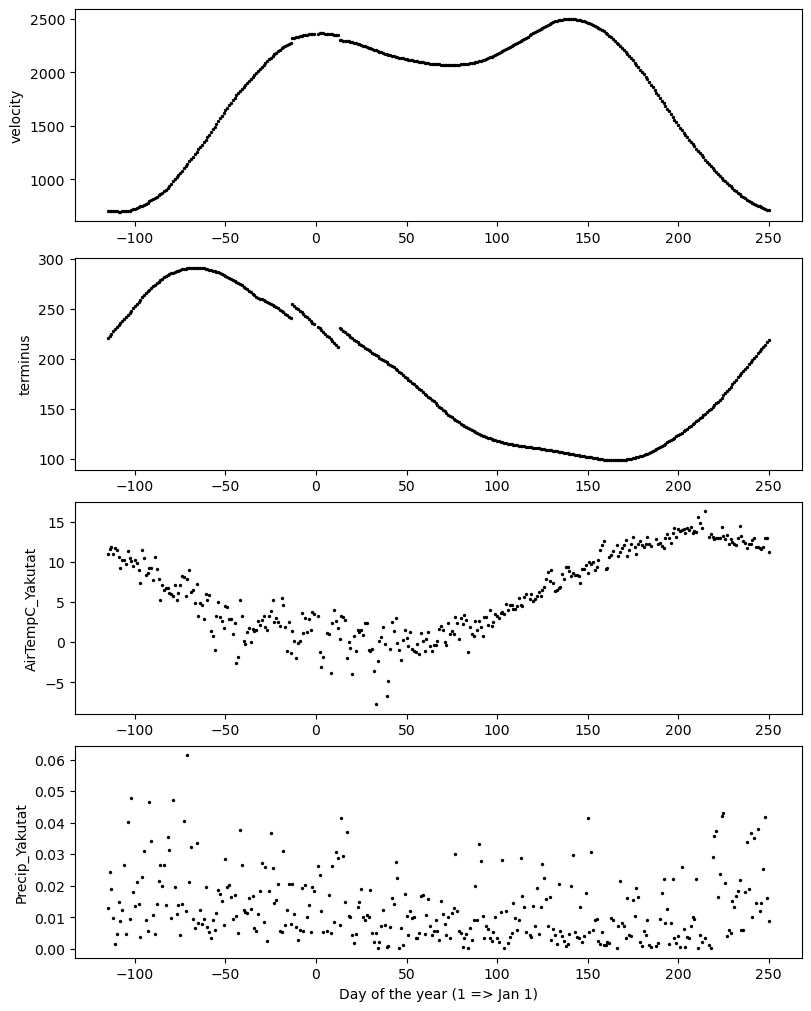

In [17]:
# can replace df_avyr by df_all to only average over sections and not year
fig, ax = plt.subplots(4,1, layout='constrained', figsize=(8,10))
# plt.scatter
ax[0].update
i = 0
for col in df_avyr:
    if col == "Date":
        continue
    ax[i].scatter(df_avyr["Date"], df_avyr[col], 2, color="black"); ax[i].set_ylabel(col)
    # ax[i].scatter(tres[0:-1], df_avyr[col], 2, color="black"); ax[i].set_ylabel(col)
    # ax[i].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    # ax[i].xaxis.set_minor_locator(mdates.MonthLocator())
    # ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m'))            # see https://matplotlib.org/stable/gallery/text_labels_and_annotations/date.html
    if i == len(ax)-1:
        ax[i].set_xlabel("Day of the year (1 => Jan 1)")
    i+=1
    fig.savefig("four-panel-yearly.jpg")